This is only a slight variation of chapter 11 of [Sebastian Raschka](http://sebastianraschka.com), 2015

https://github.com/rasbt/python-machine-learning-book

# Python Machine Learning - Code Examples

# Chapter 11 - Working with Unlabeled Data – Clustering Analysis

Clustering describes a class of methods belonging to *unsupervised learning*. This means that there is no ground truth we want to the data to fit to, which would make it *supervised learning*. Rather, we will need some way to describe *similarity* between data, since the idea of clustering is to find groups of data, where the data within the groups is similar, while the groups themselves are well distinguished and thus dissimilar.

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

Sebastian Raschka 
last updated: 2019-05-12 

CPython 3.7.2
IPython 7.3.0

numpy 1.16.2
pandas 0.24.2
matplotlib 3.0.3
scipy 1.2.1
sklearn 0.21.0


In [2]:
# to install watermark just do the following on the command line:
# pip install watermark

<br>
<br>

### Overview

- [Grouping objects by similarity using k-means](#Grouping-objects-by-similarity-using-k-means)
  - [K-means++](#K-means++)
  - [Hard versus soft clustering](#Hard-versus-soft-clustering) (not discussed here)
  - [Using the elbow method to find the optimal number of clusters](#Using-the-elbow-method-to-find-the-optimal-number-of-clusters)
  - [Quantifying the quality of clustering via silhouette plots](#Quantifying-the-quality-of-clustering-via-silhouette-plots)
- [Organizing clusters as a hierarchical tree](#Organizing-clusters-as-a-hierarchical-tree)
  - [Performing hierarchical clustering on a distance matrix](#Performing-hierarchical-clustering-on-a-distance-matrix)
  - [Attaching dendrograms to a heat map](#Attaching-dendrograms-to-a-heat-map)
  - [Applying agglomerative clustering via scikit-learn](#Applying-agglomerative-clustering-via-scikit-learn)
- [Locating regions of high density via DBSCAN](#Locating-regions-of-high-density-via-DBSCAN)
- [Summary](#Summary) (to be read in the book)

<br>
<br>

In [3]:
from IPython.display import Image

# Grouping objects by similarity using k-means

*k-means* is the best-known method for clustering, which is why we will look at it here. It is very popular, because compared to other clustering algorithms, some of which we will look at later, ist is comparatively easy to implement but still computationally very efficient.

In k-means, the clusters are represented by their **centroid**s (the *average*) or their **medioid**s (most frequently occuring point). Therefore, k-means belongs to the class of **prototype-based** clustering algorithms. The algorithm turns out to be very well suited for *spherical* clusters, there is one major challenge in applying it: finding $k$, i.e. the number of clusters, which has to be specified beforehand. A poorly chosen $k$ might result in far from optimal performance, but we will see later that there are ways of (semi-)automating the choice of $k$.

To illustrate how k-means works, we will look at an example using two-dimensional data. However, the algorithm can be applied in higher dimensions just the same. We start by creating 150 randomly generated points belonging to three regions where the individual points are grouped closer together.

In [31]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

Let us look at the result in a *scatter plot*.

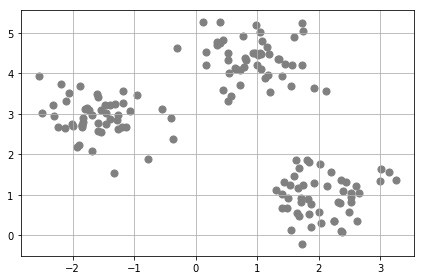

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0], X[:,1], c='grey', marker='o', s=50)
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/spheres.png', dpi=300)
plt.show()

**4-step algorithm**:
1.	 Randomly pick $k$ centroids from the sample points as initial cluster centers.
2.	 Assign each sample to the nearest centroid $\mu^{(j)} , j ∈ { 1, \dots , k }$ .
3.	 Move the centroids to the center of the samples that were assigned to it.
4.	 Repeat steps 2 and 3 until the cluster assignments do not change or a user-defined tolerance or a maximum number of iterations is reached.

*How to we measure similarity*? 

* similarity $:=$ *opposite of distance*
* for continuous features use **squared Euclidean distance** :
  sample points $x, y\in \mathbb{R}^m$
$$
d ( \mathbf{x} , \mathbf{y} ) = \sum_{j=1}^m ( x_j − y_j )^2 = \left\lVert{\mathbf{x} − \mathbf{y}}\right\rVert_2^2
$$
* Above: $j$ refers to $j$-th dimension (feature column) of the  $x$ and $y$. 
* Further: superscripts $i$ and $j$ to refer to sample index and cluster index, respectively.

$ \longrightarrow $ k-means algorithm is **optimization problem**, i.e. *iterative approach* for minimizing the **within-cluster sum of squared errors (SSE)** (aka **cluster inertia**):
$$
SSE = \sum_{i=1}^n\sum_{j=1}^k w^{ ( i, j ) }\left\lVert{\mathbf{x}^{(i)} - \mathbf{\mu}^{(j)}}\right\rVert_2^2
$$

* $\mathbf{\mu}^{(j)}$ is centroid for cluster $j$
* weights $w$: $ w^{ ( i, j )} = 1 $ if the sample $ x^{ ( i )} $ is in cluster $j$; $ w^{ ( i, j )} = 0 $ otherwise.

Next, we use the simple k-means to generate the clusters and predict the cluster labels for the individual samples.

In [40]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, 
            init='random', # leave this out for k-means++ (see below)
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)
print(y_km)
print(y_km==0,0)
print(y_km==0,1)

[1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]
[False  True  True  True False  True  True False False  True False False
 False  True  True False False False False False  True False  True  True
 False False False  True False False False False False False  True False
 False False  True  True False False  True False False False False  True
 False  True False  True  True False False False  True False False  True
 False False False False  True False  True False  True  True  True False
 False  True False  True  True False False  True False False  True  True
 False False False False False False False  True False  True False  True
 False False False False False False False False False  True False  True
  True  True False  True False False 

An then we can visualize the results:

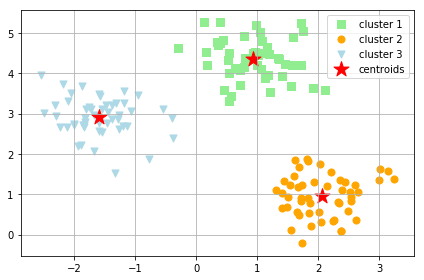

In [36]:
plt.scatter(X[y_km==0,0], 
            X[y_km==0,1], 
            s=50, 
            c='lightgreen', 
            marker='s', 
            label='cluster 1')
plt.scatter(X[y_km==1,0], 
            X[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            label='cluster 2')
plt.scatter(X[y_km==2,0], 
            X[y_km==2,1], 
            s=50, 
            c='lightblue', 
            marker='v', 
            label='cluster 3')
plt.scatter(km.cluster_centers_[:,0], 
            km.cluster_centers_[:,1], 
            s=250, 
            marker='*', 
            c='red', 
            label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids.png', dpi=300)
plt.show()

<br>

## K-means++

Problem: random seeding of starting centroids might lead to bad performance!
$\rightarrow$ paper [*k-means++: The Advantages of Careful Seeding.*](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)

**Idea**:  place initial centroids far away from each other by means of:

1. Initialize an empty set **M** to store the $k$ centroids being selected.
2. Randomly choose the first centroid $\mu^{(1)}$ from the input samples and assign it to **M**.
3. For each sample $\mathbf{x}^{(i)}\notin \mathbf{M}$,
   find the minimum squared distance
   $d(\mathbf{x}^{(i)}, \mathbf{M})^2$ to any of the centroids in **M**.
4. To randomly select the next centroid $\mu^{(p)}$, use a weighted probability distribution equal to
   $$
   \frac{d(\mathbf{\mu}^{(p)}, \mathbf{M})^2}{\sum_i d(\mathbf{x}^{(i)}, \mathbf{M})^2}
   $$ 
5. Repeat steps 3 and 4 until $k$ centroids are chosen.

After this seeding process, the normal k-means algorithm is applied.

The basic idea behind this is that a point very far away from a cluster center probably does not belong to the corresponding cluster. So, choosing the next centroid according to the probability distribution makes it more likely to choose a suitable centroid right away.

### Empty clusters

clusters may have a centroid and no other members $\rightarrow$ find sample farthest away from the lonely centroid and take this as the centroid instead.

## Hard versus soft clustering

*will be left for the interested student to read in Raschka's book*

## Using the elbow method to find the optimal number of clusters 

no ground truth $\rightarrow$ *explorative* analysis and quality must be measured *intrinsically*;
for k-means we can compute the SSE or **cluster inertia** called *distortion*:

In [8]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


**Elbow-Idea**
The more clusters we have, the less distortion we will get until there is no distortion at all if we have one cluster for each sample. Obviously, the latter makes no sense and having $k=1$ does not either. So, we will look for a $k$ from which on the decrease in distortion will be noticeably less than it was up until that point.

So, we can try out a few $k$ and look at the plot, which should give us a good indication for a suitable $k$ which will provide a good trade-off between over- and underfitting providing good *generalization*.

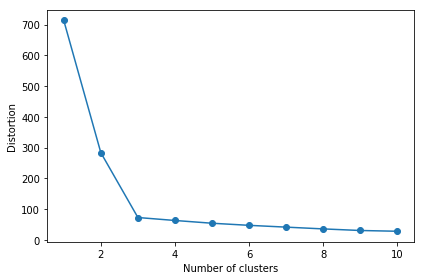

In [9]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', # this can be left out, as it is the default
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

Obviously, as expected, $k=3$ is the number of clusters to use here.

## Quantifying the quality of clustering  via silhouette plots

1. *cohesion* $a^{(i)}$: average distance between sample $\mathbf{x}^{(i)}$ and all other points in the same cluster (similarity within cluster)
2. *separation* $b^{(i)}$: average distance between sample $\mathbf{x}^{(i)}$ and all samples in the nearest cluster (dissimilarity to other clusters)
3. *silhouette* $s^{(i)}$:
   $$
     s^{(i)} := \frac{b^{(i)} - a^{(i)}}{\text{max}\{b^{(i)},a^{(i)}\}}\quad\in[-1,1]
   $$
   
Ideally, $b^{(i)}>>a^{(i)} \Rightarrow s^{(i)}\approx 1$

`silhouette_samples` available in scikit-learn (<tt>metric</tt> module)!

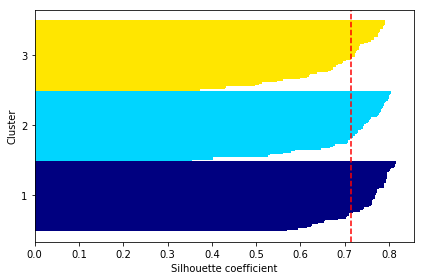

In [10]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

Nice, no silhouette value is even close to zero! Thus, three clusters seems to do it.

### Comparison to "bad" clustering:

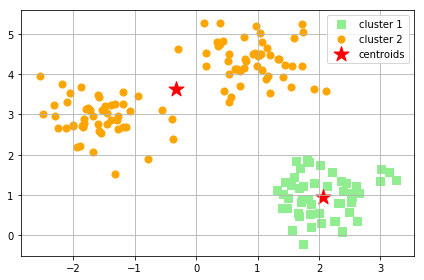

In [11]:
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0], 
            X[y_km==0,1], 
            s=50, 
            c='lightgreen', 
            marker='s', 
            label='cluster 1')
plt.scatter(X[y_km==1,0], 
            X[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            label='cluster 2')

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids_bad.png', dpi=300)
plt.show()

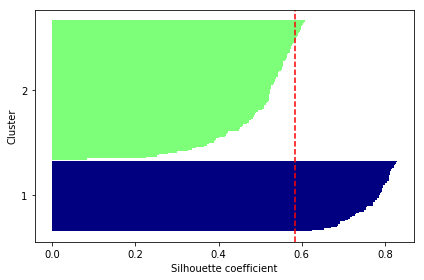

In [12]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette_bad.png', dpi=300)
plt.show()

For cluster 2, there are samples whose cohesion is more or less the same as the separation $\rightarrow$ not good!

**Note**: this can be visualized even when the samples have more than two dimensions (where the scatter plots will not make a lot of sense)

# Organizing clusters as a hierarchical tree

Advantages:
* number of clusters does not have to be specified beforehand
* visualization via [dendrograms](https://www.displayr.com/what-is-dendrogram/) is possible

Two main approaches:
* *divisive*, i.e. starting with all samples in one cluster and doing binary splits until there is a cluster for each sample
* *agglomerative*, i.e. starting with one cluster for each sample and combining two clusters until there is one cluster containing all samples

Suitable number of clusters is subsequently chosen by looking at the results (possibly using dendrograms).

**Criterion for cluster combination**: *linkage* in variants *single, complete, average, Ward's* or others;
then combine those clusters which have the minimum distance according to linkage chosen.

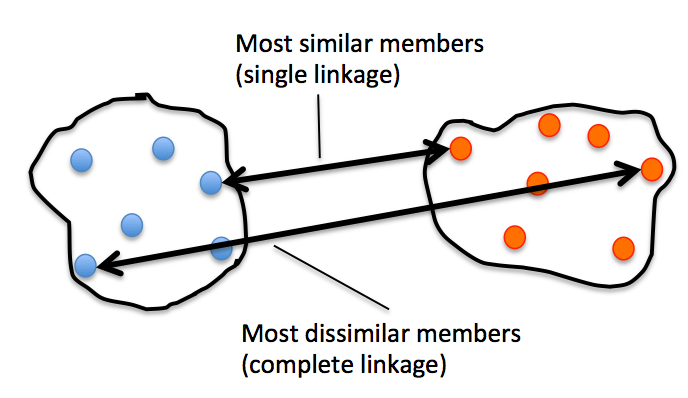

In [13]:
Image(filename='./images/11_05.png', width=400) 

**Agglomerative Clustering**

Iterative procedure as follows:
1. Compute the distance matrix of all samples.
2. Represent each data point as a singleton cluster.
3. Merge the two closest clusters based on the distance of the most dissimilar(distant) members.
4. Update the distance matrix.
5. Repeat steps 2 to 4 until one single cluster remains.

*Example* Random generation of five random samples ID_0, ..., ID_4 with three features X, Y, Z:

In [14]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
itemlabels = ['ID_0','ID_1','ID_2','ID_3','ID_4']

X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=itemlabels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<br>

## Performing hierarchical clustering on a distance matrix

Computation of the distance matrix:

In [15]:
from scipy.spatial.distance import pdist,squareform

row_pdist = pdist(df, metric='euclidean')
row_dist = pd.DataFrame(squareform(row_pdist), columns=itemlabels, index=itemlabels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Compare this to the output of <tt>pdist</tt>:

In [16]:
row_pdist

array([4.973534  , 5.51665266, 5.89988504, 3.83539555, 4.34707339,
       5.10431109, 6.69823298, 7.24426159, 8.31659367, 4.382864  ])

Since the distance matrix is symmetrical with zeroes on the diagonal, we really only need the upper triangular values!

*Computing the **linkage matrix**:* 

We can either pass a condensed distance matrix (upper triangular) from the `pdist` function, or we can pass the "original" data array and define the `metric='euclidean'` argument in `linkage`. However, we should not pass the squareform distance matrix, which would yield different distance values although the overall clustering could be the same.

In [17]:
# 1. incorrect approach: Squareform distance matrix

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
df1 = pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
df1

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [18]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
df2 = pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
df2

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [19]:
# 3. correct approach: Input sample matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')
df3 = pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])
df3

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


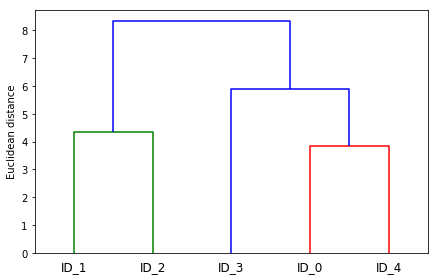

In [20]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=itemlabels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('./figures/dendrogram.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

<br>

## Attaching dendrograms to a heat map

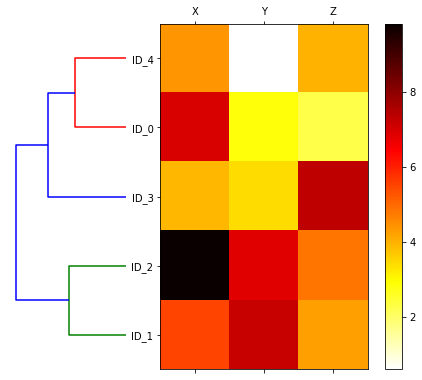

In [21]:
# plot row dendrogram
fig = plt.figure(figsize=(8,8), facecolor='white')
axd = fig.add_axes([0.09,0.1,0.2,0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23,0.1,0.6,0.6]) # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

<br>

## Applying agglomerative clustering via scikit-learn

In [22]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 0 0 2 1]


In order to plot a dendrogram from this, we can have a look at the relevant example in [scikit learn](https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py) and adapt it to our case:

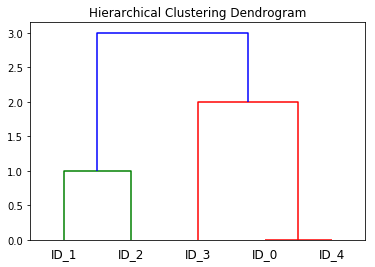

In [23]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(ac, labels=itemlabels)
plt.show()

# Locating regions of high density via DBSCAN

Density-based Spatial Clustering of Applications with Noise (DBSCAN)

+ *density* = number of points within specified radius $\varepsilon$
+ *core point*: at least a specified number $n_{\text{min}}$ of neighboring points fall within the specified radius $\varepsilon$
+ *border point*: has fewer neighbors than $n_{\text{min}}$ within but lies within the $\varepsilon$ radius of a core point
+ *noise point*: points that are neither core nor border points


**DBSCAN Algorithm**

1. Label points as core, border or noise points
2. Form a separate cluster for each core point or a connected group of core points (core points are connected if they are no farther away than $\varepsilon$ ).
3.	 Assign each border point to the cluster of its corresponding core point.

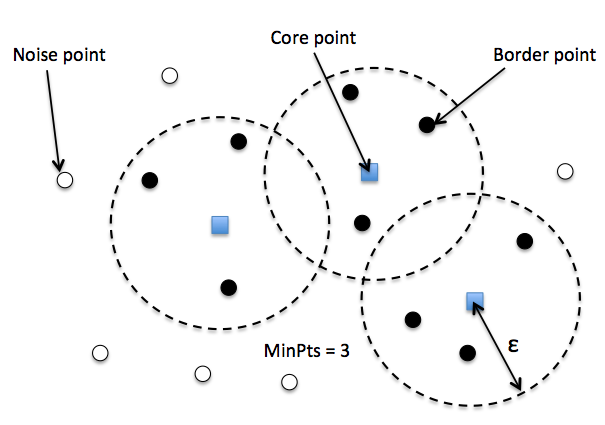

In [24]:
Image(filename='./images/11_11.png', width=500) 

- Advantage of DBSCAN is mainly that shape of clusters does *not* have to be *spherical*
- noise points will not be clustered $\rightarrow$ outlier detection

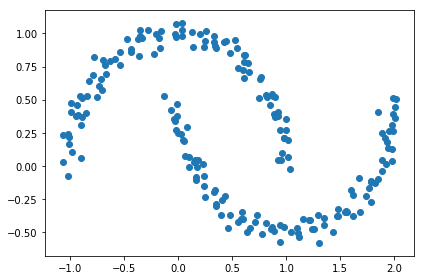

In [25]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.tight_layout()
#plt.savefig('./figures/moons.png', dpi=300)
plt.show()

*Visually*, two clusters are recognized immediately. However ....

#### K-means and hierarchical clustering:

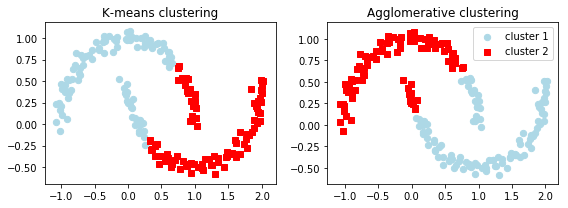

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km==0,0], X[y_km==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km==1,0], X[y_km==1,1], c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac==0,0], X[y_ac==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac==1,0], X[y_ac==1,1], c='red', marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
#plt.savefig('./figures/kmeans_and_ac.png', dpi=300)
plt.show()

#### Density-based clustering:

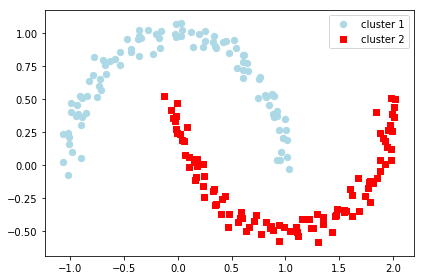

In [27]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db==0,0], X[y_db==0,1], c='lightblue', marker='o', s=40, label='cluster 1')
plt.scatter(X[y_db==1,0], X[y_db==1,1], c='red', marker='s', s=40, label='cluster 2')
plt.legend()
plt.tight_layout()
#plt.savefig('./figures/moons_dbscan.png', dpi=300)
plt.show()

*Disadvantages of DBSCAN*

- [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) increases with number of features
- $\varepsilon$ and $n_{\text{min}}$ must be optimized for good results $\rightarrow$ might be hard

# Additional Notes

* Many more clustering algorithms exist
* The performance of the respective algorithms for a given problem might vary strongly (see the half moon example above)
* Hyperparameters always have to be optimized
* The choice of distance metric has a large influence (see the documentation for the [<tt>pdist</tt>-function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) to get an idea)
* In our examples, all the numbers were on the same order of magnitude. In real world examples, it is often necessary to **normalize** or **standardize** the data so that the numbers are on the same scale. This is particularly true for clustering, since otherwise the distances of some features will clearly dominate the others (for more information see the section *Bringing features onto the same scale* in chapter 4 of Raschka's book or [this thread on Stackoverflow](https://stackoverflow.com/questions/15777201/why-vector-normalization-can-improve-the-accuracy-of-clustering-and-classificati))
* Like most data science tasks, clustering problems need *domain knowledge*, so must be solved in *interdisciplinary teams*.

# Summary

...